<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:
    
* It is expected, that **LSA SAF DMETv3** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFAPAR/NETCDF/) in `NetCDF4` format for the period from Februar 29, 2022 to October 30, 2022 and from April 1, 2022 to october 31, 2022 and saved locally.
* It is expected, that **LSA SAF METREF** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFAPAR/NETCDF/) in `NetCDF4` format for the period from Februar 29, 2022 to October 30, 2022 and from April 1, 2022 to october 31, 2022 and saved locally.

</div>

<hr>

# Indicating Water Deficit with the Discrepancy Between Actual and Reference Evapotranspiration

#### About

This notebook follows the work done in a [show case](https://landsaf.ipma.pt/en/news/news/discrepancy-between-reference-evapotranspiration-and-actual-evapotranspiration-as-an-indicator-of-water-deficit/), published on the [LSA SAF webpage](https://landsaf.ipma.pt/en/applications/agrometeorology/). As in the show case, we analyze evapotranspiration (ET) at the following two locations in Southeast Europe: Nova Gorica, Slovenia and Iasi County, Romania. Here we use ET data in the years 2020 and 2022, contrary to the showcase where 2013 and 2020 are used.
Additionally, we choose LSA SAF newly developed product MSG Daily Evapotranspiration v3 [Dmetv3 [LSA-312.3]](https://landsaf.ipma.pt/en/data/products/evapotranspiration-turbulent-fluxes/) instead of the older product [DMET [LSA-311]](https://landsaf.ipma.pt/en/data/products/evapotranspiration-turbulent-fluxes/) for providing estimates of actual evapotranspiration on a daily basis. To assess the atmospheric evaporative demand irrespective of vegetation conditions, we are using LSA SAF MSG Reference Evapotranspiration [METREF [LSA-303]](https://landsaf.ipma.pt/en/data/products/evapotranspiration-turbulent-fluxes/). It corresponds to the evapotranspiration from a well-watered surface (i.e., a field covered with 12 cm height green grass with albedo of 0.23) at the given down-welling short-wave radiation.

The discrepancy between the actual and reference value of ET can be understood as an indicator of water deficit.

The process of ET is primarily influenced by the amount of available sunlight, soil moisture as well as the characteristics of the land cover (such as vegetation, surface water, or bare soil). The DMETv3 values vary according to factors such as latitude, seasonal variations, and cloud cover. 

Although DMET and METREF are associated with different land covers, comparing them can still yield meaningful insights, such as water deficit. Over two years we are comparing the vegetation season in terms of periods with water deficit, i.e., droughts.

The LSA SAF products will be accessed in the `NetCDF4` format via the LSA SAF THREDDS data server [THREDDS server](https://thredds.lsasvcs.ipma.pt/).

#### How to access the data

For this example, DMET-v3 estimations for the period from February 29, 2022, to October 30, 2022, and for the period from April 1, 2022, to October 31, 2022 are needed and the METREF estimations for the same time intervals. All measurements are available as NetCDF4 as well as HDF5 files, but only the former will be used here. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration.

Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program.

#### Basic Facts on DMETv3 Product
> **Product number**: LSA-312.3 and LSA-351
>
> **Spatial resolution**: 3 km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 1 day
> 
> **Data availability**: 2021-NRT and data records 2004-2020


#### Basic Facts on METREF Product
> **Product number**: LSA-303
>
> **Spatial resolution**: 3 km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 1 day
> 
> **Data availability**: from 2016-NRT


#### Accessing the Data 
Data can be accessed in the `NetCDF4` format from the [LSA SAF THREDDS data server (https://thredds.lsasvcs.ipma.pt/).

#### Module Outline:
* [1 - Accessing THREDDS Data Server Example](#First)
* [2 - Defining Helper Functions](#Second)
* [3 - Accessing the METREF and MDMETv3 Values](#Third)
* [4 - Plotting and Discussion](#Forth)

<hr>

#### Load Required Libraries

In [1]:
import matplotlib.pyplot as plt     # A library the provides plotting capability
import datetime as dt               # A library that allows us to work with dates and times
import xarray as xr                 # A library that helps us work with multi-dimensional labeled arrays
import numpy as np                  # A library that lets us work with arrays
import pandas as pd                 # A library for data analysis and work with labeled data
from tqdm import tqdm               # A library to display progress bar

# Set the matplotlib backend to inline
%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = [13, 8]

## <a id='First'></a>1. Accessing THREDDS Data Server Demonstration

The data will be accessed through [OpenDAP protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds) from the THREEDS server. This server is currently in the demonstration phase. It allows the user to only load a subset of the `NetCDF4` file, for instance only a 2D (lat-lon) slice or a list of points.

To access the data, one needs to [register](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/credentials/register). The examples on how to access the THREDDS server are available [here](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds), while the documentation is available [here](https://www.unidata.ucar.edu/software/tds/). A catalog of available products is accessible with a prior registration [here](https://thredds.lsasvcs.ipma.pt/thredds/catalog/catalog.html).

Here we use the `xarray.open_dataset()` function to access the THREDDS data. The URL location of the dataset needs to be specified as follows: `https://<USERNAME>:<PASSWORD>@thredds.lsasvcs.ipma.pt/thredds/dodsC/<satellite>/<product>/<format>/<year>/<month>/<day>/filename`.

We start with the username and password:

In [2]:
USER = "***"
PASSWD = "***"

Then we define our `xarray.DataSet`. The `xarray` library uses "lazy loading", therefore the data will be loaded, when we use `DataSet.load()` or call the data in the dataset. An example for accessing the METREF product for 1 July 2020 will be made here, to demonstrate the use of the THREDDS server. We will print and plot the dataset.

<xarray.Dataset> Size: 164MB
Dimensions:       (lat: 3201, lon: 3201, time: 1)
Coordinates:
  * lat           (lat) float32 13kB 80.0 79.95 79.9 ... -79.9 -79.95 -80.0
  * lon           (lon) float32 13kB -80.0 -79.95 -79.9 ... 79.9 79.95 80.0
  * time          (time) datetime64[ns] 8B 2020-07-01
Data variables:
    crs           |S64 64B ...
    METREF        (time, lat, lon) float64 82MB ...
    quality_flag  (time, lat, lon) float64 82MB ...
Attributes: (12/29)
    references:                      Data provided by the EUMETSAT Satellite ...
    easternmost_longitude:           -80.0
    westernmost_longitude:           80.0
    spatial_resolution:               0.05x 0.05
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_resolution:        0.05
    geospatial_lon_resolution:        0.05
    northernmost_latitude:           80.0
    southernmost_latitude:           -80.0
   

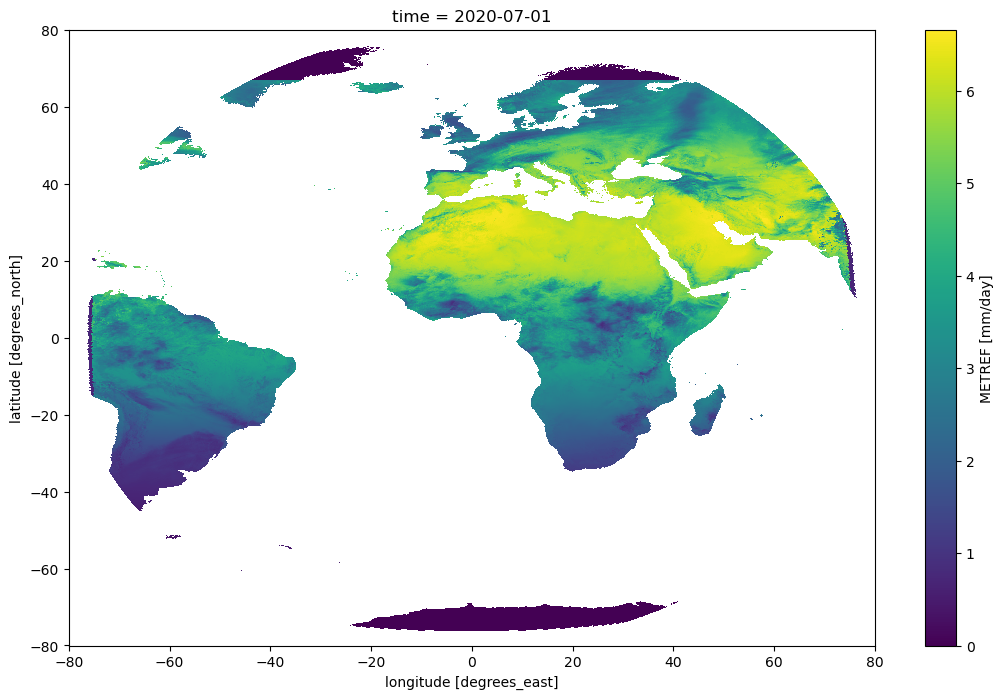

In [3]:
# Define the dataset
test_ds = xr.open_dataset(
    "https://"
    + USER
    + ":"
    + PASSWD
    + "@thredds.lsasvcs.ipma.pt/thredds/dodsC/MSG/METREF/NETCDF/2020/07/01/NETCDF4_LSASAF_MSG_METREF_MSG-Disk_202007010000.nc"
)

# Print the dataset
print(test_ds)

# Plot the dataset
test_ds.METREF.plot()

# Free the memory
test_ds.close()

## <a id='Second'></a>2. Defining Helper Functions

In this section, we will define some Python functions, that will simplify our work later: `day_of_year_to_date()` which takes the consecutive number of the day in a year and returns the `datetime` object, `get_URL()`, which returns the URL address of the appropriate `NetCDF4` file on the THREDDS server and `get_data()`, that access the `NetCDF4` file over a period of interest on the THREDDS server and returns the value of LSA SAF product for the defined locations.

We will construct a list of dates in a year, by transforming the consecutive day of the year number to date rather than using for instance `pandas.daterange()` to avoid potential problems with the 29th of February in leap years and therefore having data series of different lengths for different years. In this example, we are therefore analyzing only the first 365 days in a year independently of the fact that we might be dealing with 365 or 366 days.

In [4]:
def day_of_year_to_date(year, day_in_year):
    """
    The function takes the consecutive number of the day of the year
    and returns the datetime object.

    Counting starts with 0 (day_in_year=0 is January 1)
    """
    # January 1st of the given year
    base_date = dt.datetime(year, 1, 1)

    # Add the number of days
    target_date = base_date + dt.timedelta(days=int(day_in_year))

    return target_date

The `get_URL()` function specifies the location of the desired NETCDF file on the THREDSS server according to the format, described in the first chapter of this notebook and available [here](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds). The function is defined so, that allows accessing three different LSA SAF products, specified by a function argument. Products MDMETv3, MDMET and METREF are supported.

There is a difference in the naming of the product MDMETv3 (and DMET) in the THREDDS folder name (MDMETv3) and inside the `NetCDF4` filename (DMETv3). This is also taken into account in the `get_URL()` function.

In [5]:
def get_URL(date, product):
    """
    Returns the URL address of the NetCDF4 file of interest.
    Arguments:
        -date: pd.datetime object
        -product: string ("MDMETv3", "MDMET", "METREF")
    Returns:
        -url: string
    """

    # MDMETv3 has different folder_name than filename  MDMETv3 vs DMETv3
    product_name_2 = product

    if product == "MDMETv3":
        product_name_2 = "DMETv3"

    if product == "MDMET":
        product_name_2 = "DMET"

    # Define the filename
    url = (
        "https://"
        + USER
        + ":"
        + PASSWD
        + "@thredds.lsasvcs.ipma.pt/thredds/dodsC/MSG/"
        + product
        + "/NETCDF/"
        + str("{:02d}".format(date.year))
        + "/"
        + str("{:02d}".format(date.month))
        + "/"
        + str("{:02d}".format(date.day))
        + "/"
        + "NETCDF4_LSASAF_MSG_"
        + product_name_2
        + "_MSG-Disk_"
        + str("{:02d}".format(date.year))
        + str("{:02d}".format(date.month))
        + str("{:02d}".format(date.day))
        + "0000.nc"
    )

    return url

Additionaly, we will define the `get_data()` function that returns an array of product values at the selected locations (points). The `xarray` allows the extraction of values in the `NetCDF4` files, based on their coordinates. In this case, we are extracting product values for a number of points, defined by the list of latitudes and longitudes using `dataset.sel()`. A detailed description of the approach is available [here](https://docs.xarray.dev/en/latest/user-guide/indexing.html). This approach automatically chooses the nearest data point to our desired location from the `NetCDF4()` file, but we need to specify the name of the variable of interest since each `NetCDF4` file consists of multiple variables (product value, uncertainty, quality flag ...). In this case, this is handled by a series of `if` statements.

In [6]:
def get_data(date, product, lat_input, lon_input):
    """
    Loads vegetation product into a dataset and returns value for one particular location
    Atributes:
        -product = string ("MDMETv3","MDMET" "METREF")
        -date = pd.datetime
        -lat, lon = list of floats
    Returns:
        -product values in points = np.array
    """

    # Define the names of the data variables
    if product == "MDMETv3":
        variable = "ET"
    elif product == "MDMET":
        variable = "ET"
    elif product == "METREF":
        variable = "METREF"
    else:
        raise ValueError("Wrong product string. Must be MDMETv3 or METREF")

    # Define lists of latitudes and longitudes
    target_lat = xr.DataArray(lat_input, dims="points")
    target_lon = xr.DataArray(lon_input, dims="points")

    # Define the dataset
    LSA_SAF_ds = xr.open_dataset(
        get_URL(date, product),
        decode_times=False,
    )

    # Extract the values of the product
    LSA_SAF_value = (
        LSA_SAF_ds.sel(lat=target_lat, lon=target_lon, method="nearest")[variable]
        .load()
        .values[0]
    )

    # Close dataset, to free the memory
    LSA_SAF_ds.close()

    return LSA_SAF_value

## <a id='Third'></a>3. Accessing the METREF and MDMETv3 Values

The locations (i.e., the nearest satellite pixels) in Nova Gorica, Slovenia and Iasi County, Romania were selected due to their consistent vegetation cover and minimal presence of nearby urban areas. We store name, lat, lon and vegetation type in `pandas.DataFrame`.

In [7]:
# Create list of products to be plotted
products = [
    "METREF",
    "MDMETv3",
]

# Dataframe containing locations and descriptions is constructed
locations_df = pd.DataFrame(
    [
        ["SI, Nova Gorica", 45.909997, 13.628889, "Vineyards"],
        ["RO, Iasi County", 47.328, 27.179, "Fields"],
    ],
    columns=["Name", "lat", "lon", "Type"],
)

# Check the dataframe
print(locations_df)

              Name        lat        lon       Type
0  SI, Nova Gorica  45.909997  13.628889  Vineyards
1  RO, Iasi County  47.328000  27.179000     Fields


We have to generate the list of datetime objects for the selected years (2020, 2022) using  `day_of_year_to_date()` function defined in [2 - Defining Helper Functions](#Second). It accepts only scalar inputs, therefore it needs to be vectorized using `np.vectorize()`, and thus allowed to operate on arrays element-vise. To construct a list of dates we just call the vectorized function over a list of consecutive days in the year of the interest.

Since we are only interested in the growing period of vegetation, we limit ourselves to the period from March to November, which corresponds to the day numbers from 59 to 304 for a common year. The same day numbers are also used for a leap year case (the 2020 year).

In [8]:
# Create a list of years of the interest
years_list = [2020, 2022]

# Create a list of dates in a year (from March to November)
days_list = np.arange(59, 304)

day_of_year_to_date_vec = np.vectorize(day_of_year_to_date)

In the next step, we define `np.array` to store the results. We want to populate it with `NaN` values so that entries with missing data will be automatically populated with `NaN` values.

In [9]:
results = np.full(
    (len(products), len(years_list), locations_df.shape[0], len(days_list)), np.nan
)

When running the function `get_data()` it is advised to be aware of the potential errors in accessing the THREDDS server, for instance, wrong credentials or troubles with the connection. The errors can be printed by setting the following parameter to `True`.

In [10]:
ERROR_OUTPUT=True

In the next step, we retrieve DMETv3 and METREF values. We iterate over all days in a year, over the years of interest and over both products (METREF and DMETv3). But we do not need to iterate over the locations, since the function `get_data()` returns values for all defined locations.

In [11]:
for i, date in tqdm(enumerate(days_list)):
    for j, year in enumerate(years_list):
        for k, product in enumerate(products):
            try:
                results[k, j, :, i] = get_data(
                    day_of_year_to_date(year, date),
                    product,
                    locations_df["lat"],
                    locations_df["lon"],
                )

            except Exception as e:
                if ERROR_OUTPUT:
                    print(e)

245it [08:25,  2.06s/it]


## <a id='Forth'></a>4. Plotting and Discussion

We can present a discrepancy between METREF and DMETv3 on a scatter plot in the same manner as done in an [online example](https://landsaf.ipma.pt/en/news/news/discrepancy-between-reference-evapotranspiration-and-actual-evapotranspiration-as-an-indicator-of-water-deficit/). We are plotting measurements for the same location in the same row and the same year in the same column with the METREF on the horizontal and MDMETv3 on the vertical axe. We can also plot an additional linear function (red line) for easier visualization.

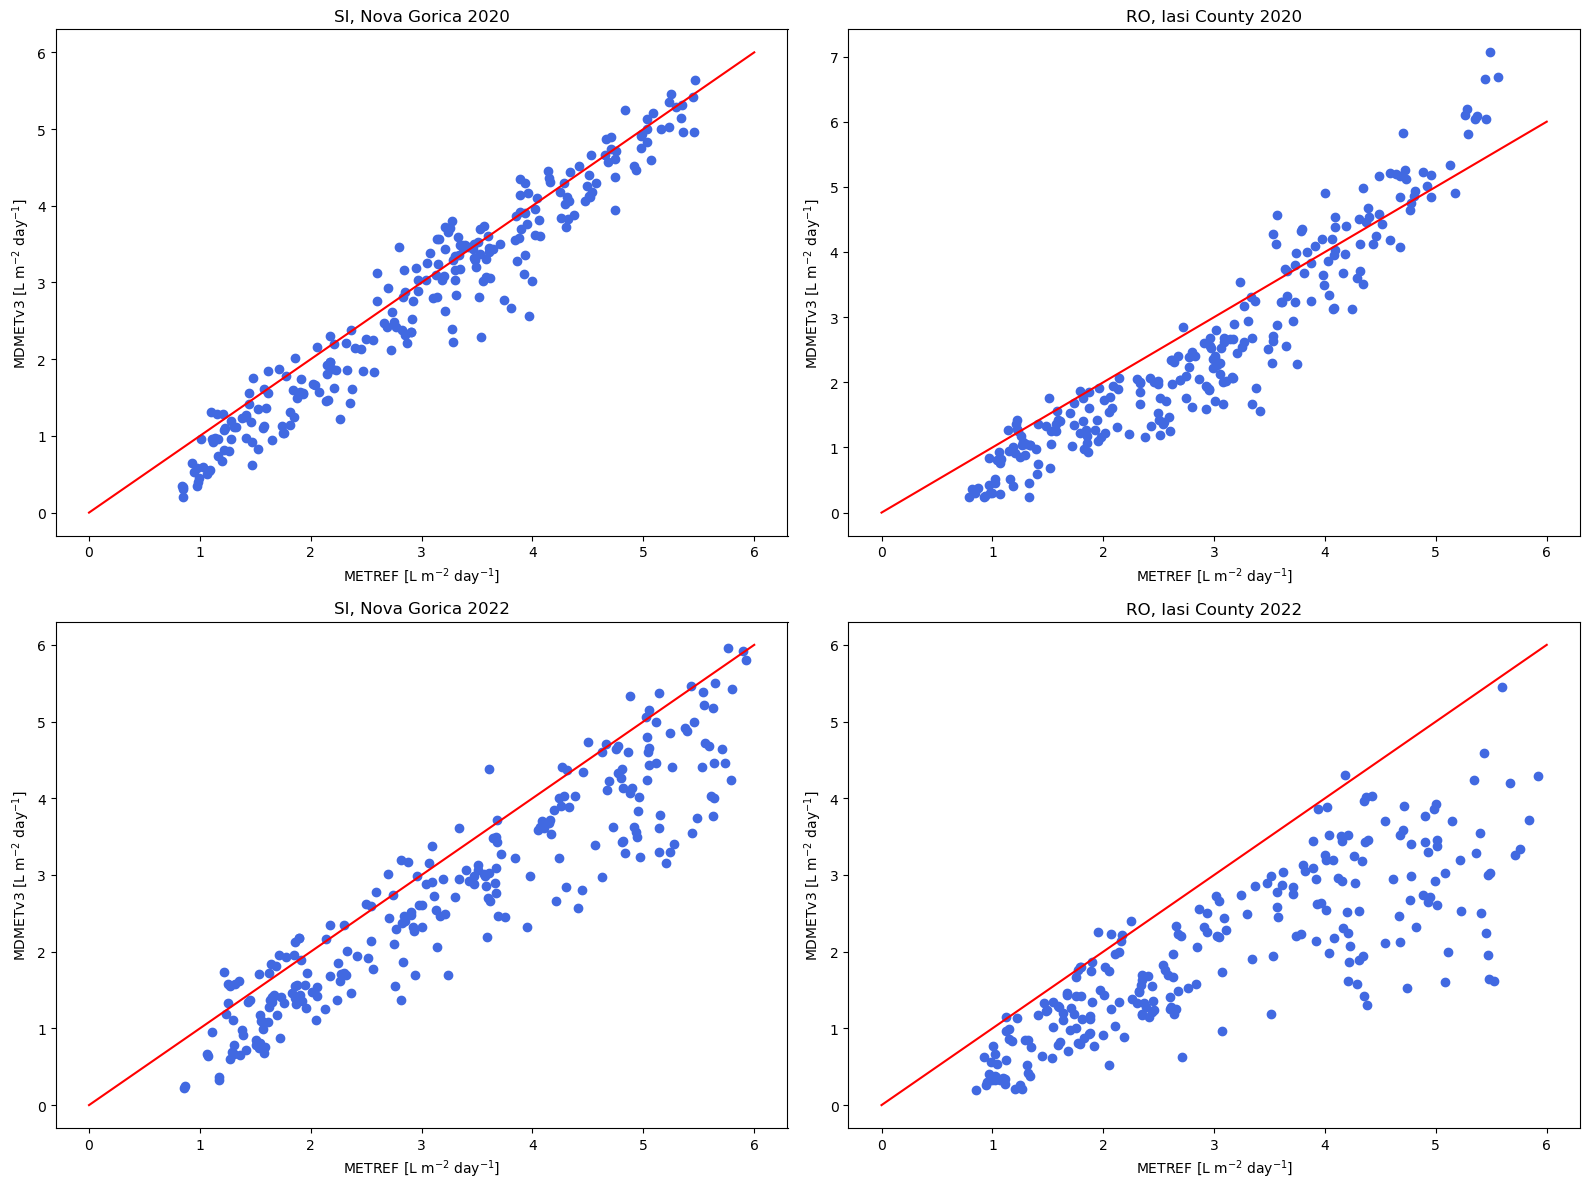

In [12]:
# Define figure and axes
fig, ax = plt.subplots(
    len(years_list), locations_df.shape[0], figsize=(16, 12), squeeze=False
)

# Loop over locations and years
for i, year in enumerate(years_list):
    for j, location in enumerate(locations_df["Name"]):

        # Plot datapoints
        ax[i, j].scatter(results[0, i, j, :], results[1, i, j, :], c="royalblue")

        # Plot the y=x line
        ax[i, j].plot([0, 6], [0, 6], c="red")

        # Customize the plot
        ax[i, j].set_xlabel(products[0]+r" [L m$^{-2}$ day$^{-1}$]")
        ax[i, j].set_ylabel(products[1]+r" [L m$^{-2}$ day$^{-1}$]")
        ax[i, j].set_title(location + " " + str(year))


plt.tight_layout()

As long as data points align on the red line, the METREF and DMETv3 values agree. When they are away from the red line, this indicates discrepancy, which can be interpreted as smaller water availability in the ground (data points under the red line) or increased water availability in the ground (data points over the red line).

In 2020, there is almost no disagreement between DMETv3 and METREF, which indicates, that amount of available water was normal in Nova Gorica and slightly subnormal in Iasi County.

Contrary, we can see a negative discrepancy at both locations in 2022. A significant amount of data points deviates from the red line, which indicates a lack of water and can be interpreted as an indicator of drought. This can be additionally investigated if we plot DMETv3 and METREF as a function of time.

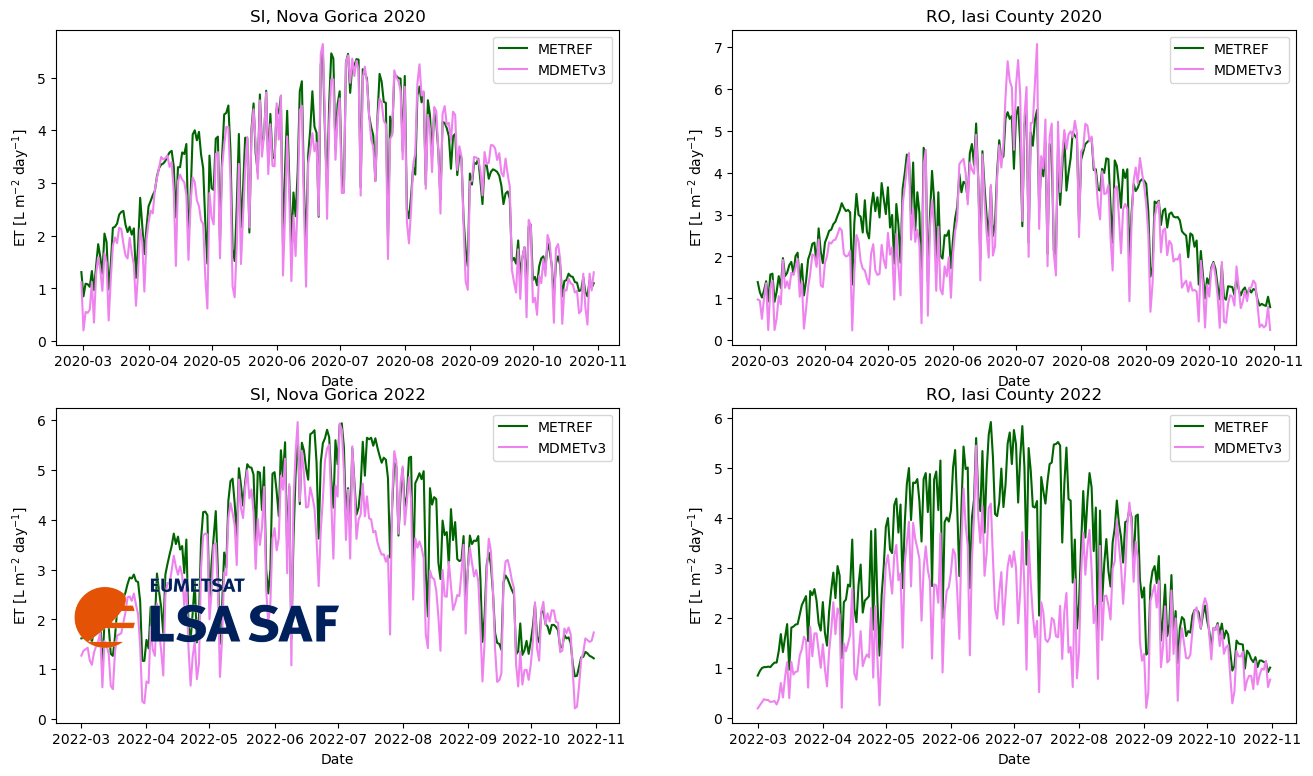

In [13]:
# Define figure and axes
fig, ax = plt.subplots(len(years_list), locations_df.shape[0], figsize=(16, 9), dpi=100, squeeze=False)

# Define list of colors
colors = ["darkgreen", "violet"]

# Loop over years, locations and products
for i, year in enumerate(years_list):
    for j, location in enumerate(locations_df["Name"]):
        for k, product in enumerate(products):

            # Plot the time series of the product
            ax[i, j].plot(
                day_of_year_to_date_vec(year, days_list),
                results[k, i, j, :],
                color=colors[k],
                label=product,
                lw=1.5
            )

            # Customize plot
            ax[i, j].set_ylabel(r"ET [L m$^{-2}$ day$^{-1}$]")
            ax[i, j].set_xlabel("Date")
            ax[i, j].set_title(location + " " + str(year))
            ax[i, j].legend()

#Set tight_layout() to avoid subplots overlap
#plt.tight_layout()

# Load and resize logo
logo = plt.imread('/home/primozic/Repositories/LSASAF_NoName_Colour.png')

newax = fig.add_axes([0.12,0.1,0.2,0.2], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')

# Figure can be saved with (uncoment)
plt.savefig("img/etp_1_twitter.png")

As before, we can indicate, that there was no major discrepancy observed at both locations in 2020. There might be a minor water deficit in Iasi County in April and September 2020.

In 2022, there are visible differences between METREF and MDMETv3. The discrepancy can be observed in Nova Gorica from July to September 2022 and in Iasi County from June to August 2022, which could indicate the presence of drought conditions.

#### Conclusion 
We demonstrated how to access the METREF data from the THREDDS server for user-defined locations. Additionally, we compared satellite-based measurements for DMETv3 and METREF in the form of scatter and line plots for selected years and locations. Both products combined can serve as an indicator of dry periods at specific locations.

#### References:

* Xarray Developers (2024). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 29.2.2024
* [https://landsaf.ipma.pt/en/news/news/discrepancy-between-reference-evapotranspiration-and-actual-evapotranspiration-as-an-indicator-of-water-deficit/](https://landsaf.ipma.pt/en/news/news/discrepancy-between-reference-evapotranspiration-and-actual-evapotranspiration-as-an-indicator-of-water-deficit/). Accesed: 29.2.2024

